<a href="https://colab.research.google.com/github/aSafarpoor/Seminar/blob/main/simple_contrastive_learning_based_on_amazon_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#read data first version

In [177]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
import random
import json
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import math
import cv2
from google.colab.patches import cv2_imshow
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/MSc/
# %mkdir SCLAD
%cd SCLAD

[Errno 2] No such file or directory: 'drive/MyDrive/MSc/'
/content/drive/MyDrive/MSc/SCLAD
[Errno 2] No such file or directory: 'SCLAD'
/content/drive/MyDrive/MSc/SCLAD


In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_AMAZON_FASHION.json.gz

In [ ]:
# !gunzip -k AMAZON_FASHION.json.gz
# !gunzip -k meta_AMAZON_FASHION.json.gz

gzip: AMAZON_FASHION.json already exists; do you wish to overwrite (y or n)? ^C
gzip: meta_AMAZON_FASHION.json already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
!ls

AMAZON_FASHION.json	meta_AMAZON_FASHION.json
AMAZON_FASHION.json.gz	meta_AMAZON_FASHION.json.gz


#data

In [ ]:
meta_data = []
for line in open('meta_AMAZON_FASHION.json', 'r'):
    meta_data.append(json.loads(line))

In [ ]:
md = pd.DataFrame(meta_data)

In [ ]:
md_text = md[~md['description'].isnull()]
md_img = md[~md['imageURL'].isnull()]

md_text_image = md_img[~md_img['description'].isnull()]
print(len(md),len(md_img),len(md_text),len(md_text_image))
del md_text 
del md_img
print('out size:',len(md_text_image))


186637 132017 15869 9810
out size: 9810


In [ ]:
df = md_text_image[:]
del md_text_image

In [ ]:
df.head()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,"X. L. Carbon Fiber Money Clip, made in the USA",Roar Carbon,"[Real Carbon Fiber, Made in USA, 5 year warran...","3,725,957inClothing,Shoesamp;Jewelry(",5 star,9654263246,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[When you pull out your extra large carbon fib...,$14.99,"[B07CQ3KY5B, B014TEOG3O, B078429G6J, B01FRG9Z7...",NaN,NaN,NaN,NaN,NaN
18,Shimmer Anne Shine Clip On Costume/Halloween C...,Shimmer Anne Shine,[Shimmer Anne Shine Clip On Costume/Halloween ...,"468,314inClothing,ShoesJewelry(",5 star,B00004T3SN,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"[A fun addition to any costume party, play, or...",$6.99,"[B00Q5RRK78, B00RN3JILE, B00PMUTNOM, B01KA5PTY...",[B01KA5PTYG],NaN,NaN,NaN,NaN
69,Buxton Heiress Pik-Me-Up Framed Case,Buxton,"[Leather, Imported, synthetic lining, Flap clo...","43,930inClothing,Shoesamp;Jewelry(",5 star,B00007GDFV,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[Authentic crunch leather with rich floral emb...,$16.95,"[B07C9V84JD, B01J6JE05G, B07J11WZ5Y, B07JJQFHS...","[B07C9V84JD, B01J6JE05G, B07JJQFHS5, B003EGITU...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN
70,Fossil Bifold Super Capacity Wallet- Chicago i...,NaN,NaN,"9,280,557inClothing,Shoesamp;Jewelry(",5 star,B000085HZL,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[Fossil Bifold Super Capacity Wallet- Chicago ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
class Normalizer:
    # based on https://www.geeksforgeeks.org/normalizing-textual-data-with-python/
    def __init__(self):
        # import regex
        self.stop_words = set(stopwords.words('english'))

    def text_normalizer(self,text):
        if type(text) == type([]):
            text = text[0]
        text = str(text)
        # convert to lower case
        lower_string = text.lower()
        # remove numbers
        no_number_string = re.sub(r'\d+','',lower_string)
        # remove all punctuation except words and space
        no_punc_string = re.sub(r'[^\w\s]','', no_number_string)
        # remove white spaces
        no_wspace_string = no_punc_string.strip()
        # convert string to list of words
        lst_string = [no_wspace_string][0].split()
        # remove stopwords
        no_stpwords_string=""
        for i in lst_string:
            if (not i in self.stop_words) and len(i)>1:
                no_stpwords_string += i+' '
        # removing last space
        no_stpwords_string = no_stpwords_string[:-1]
        output = no_stpwords_string
        return output

In [ ]:
normalizer = Normalizer()
df["description"] = df["description"].apply(normalizer.text_normalizer)
df["title"] = df["title"].apply(normalizer.text_normalizer)

In [ ]:
df = df[['title', 'description','asin','imageURL']]

In [ ]:
df = df.drop_duplicates(list(df.columns)[0:2],keep=False)
df.head()

,title,description,asin,imageURL
2,magical things really,professional amateur magician routines include...,1940280001,[https://images-na.ssl-images-amazon.com/image...
17,carbon fiber money clip made usa,pull extra large carbon fiber money clip gives...,9654263246,[https://images-na.ssl-images-amazon.com/image...
904,sterling silver cubic zirconia solitaire ring ...,classically designed silver solitaire ring las...,B00061RFTW,[https://images-na.ssl-images-amazon.com/image...
905,sterling silver cz marquise cut solitaire cubi...,sparkling magnificent sterling silver band mea...,B00061RG3M,[https://images-na.ssl-images-amazon.com/image...
909,calvin klein mens pack classic vneck tshirt,calvin klein basics comfortable cotton underwe...,B00062NHH0,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
len(df)

8528

In [ ]:
df['text'] = df.title + ' ' + df.description
df = df[['text','asin','imageURL']]

In [ ]:
df.head(3)

,text,asin,imageURL
2,magical things really professional amateur mag...,1940280001,[https://images-na.ssl-images-amazon.com/image...
17,carbon fiber money clip made usa pull extra la...,9654263246,[https://images-na.ssl-images-amazon.com/image...
904,sterling silver cubic zirconia solitaire ring ...,B00061RFTW,[https://images-na.ssl-images-amazon.com/image...


# create text embedding

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
try:
    from sentence_transformers import SentenceTransformer
except:
    ! pip install sentence_transformers
    from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
def embedding_sentenceBert(sent):
    sent_embedding = sbert_model .encode(sent)
    return sent_embedding

In [ ]:
df.head(10)

,text,asin,imageURL
0,magical things really professional amateur mag...,1940280001,[https://images-na.ssl-images-amazon.com/image...
1,carbon fiber money clip made usa pull extra la...,9654263246,[https://images-na.ssl-images-amazon.com/image...
2,sterling silver cubic zirconia solitaire ring ...,B00061RFTW,[https://images-na.ssl-images-amazon.com/image...
3,sterling silver cz marquise cut solitaire cubi...,B00061RG3M,[https://images-na.ssl-images-amazon.com/image...
4,calvin klein mens pack classic vneck tshirt ca...,B00062NHH0,[https://images-na.ssl-images-amazon.com/image...
5,pendant mizpah coin sterling silver millimeter...,B00063H8PG,[https://images-na.ssl-images-amazon.com/image...
6,mg pleated cotton twill hat band try simple cl...,B00063VWSA,[https://images-na.ssl-images-amazon.com/image...
7,bracelet silver ball rosary sterling silver mm...,B000646BWG,[https://images-na.ssl-images-amazon.com/image...
8,cross holy spirit yellow gold xmm inch necklac...,B0006468QA,[https://images-na.ssl-images-amazon.com/image...
9,kenneth cole_watch watch kc captivating person...,B000652LHY,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
tqdm.pandas()
df['embedding_of_text'] = df['text'].progress_apply(embedding_sentenceBert)

100%|██████████| 8528/8528 [44:09<00:00,  3.22it/s]


In [574]:
et = np.array(df.embedding_of_text)

In [575]:
def dot_product(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.dot(v1,v2)

def cosine_measure(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    prod = np.dot(v1,v2)
    len1 = math.sqrt(np.dot(v1, v1))
    len2 = math.sqrt(np.dot(v2, v2))
    return prod / (len1 * len2)

In [576]:
sim = np.zeros((len(et),len(et)))

In [577]:
for i in tqdm(range(len(et))):
    for j in range(len(et)):
        v1 = et[i]
        v2 = et[j]
        s = cosine_measure(v1, v2)
        sim[i][j] = s

100%|██████████| 8528/8528 [15:23<00:00,  9.23it/s]


In [578]:
simtxt = sim[:]

In [178]:
# def rounder(a):
#     return round(a,2)

# for i in range(10):
#     print(list(map(rounder,sim[i][:10])))

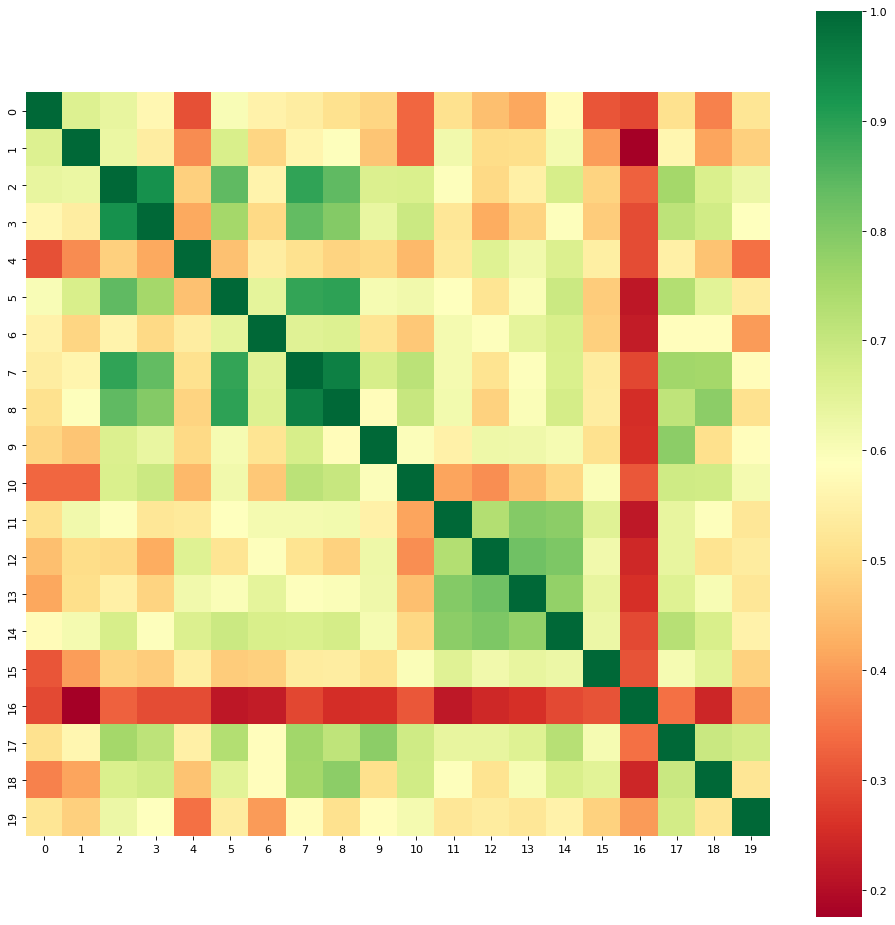

In [179]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=80)

ax = sns.heatmap(sim[:20,:20],cmap='RdYlGn',square=True)

plt.show()

In [168]:
im8name = df.imageURL[8][0]
im7name = df.imageURL[7][0]
im8name,im7name

('https://images-na.ssl-images-amazon.com/images/I/315Q84F4JHL._US40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/312JSJEPK3L._US40_.jpg')

In [175]:
!wget https://images-na.ssl-images-amazon.com/images/I/315Q84F4JHL._US40_.jpg
!wget https://images-na.ssl-images-amazon.com/images/I/312JSJEPK3L._US40_.jpg
im8 = cv2.imread("315Q84F4JHL._US40_.jpg")
im7 = cv2.imread("312JSJEPK3L._US40_.jpg")

--2022-06-24 16:07:36--  https://images-na.ssl-images-amazon.com/images/I/315Q84F4JHL._US40_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609 [image/jpeg]
Saving to: ‘315Q84F4JHL._US40_.jpg.3’

315Q84F4JHL._US40_. 100%[===================>]     609  --.-KB/s    in 0s      

2022-06-24 16:07:36 (6.35 MB/s) - ‘315Q84F4JHL._US40_.jpg.3’ saved [609/609]

--2022-06-24 16:07:36--  https://images-na.ssl-images-amazon.com/images/I/312JSJEPK3L._US40_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6

In [169]:
print(df.text[8])
print(df.text[7])

cross holy spirit yellow gold xmm inch necklace cross holy spirit yellow gold xmm inch necklace made highest quality metal shipped free pendant box make perfect gift also wear elegantly crafted symbol proudly brilliant exquisite way express anchor faith treasure keepsake years come jewelry comes satisfaction guarantee reassured happy purchase
bracelet silver ball rosary sterling silver mm inch necklace bracelet silver ball rosary sterling silver mm inch necklace made highest quality metal shipped free pendant box make perfect gift also wear elegantly crafted symbol proudly brilliant exquisite way express anchor faith treasure keepsake years come jewelry comes satisfaction guarantee reassured happy purchase


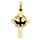

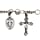

In [176]:
cv2_imshow(im8)
cv2_imshow(im7)

In [188]:
def info_printer(n):
    print(df.text[n])
    imname = df.imageURL[n][0]
    os.system("wget "+ imname)
    imname = imname.split('/')[-1]
    im = cv2.imread(imname)
    os.system("rm "+ imname)
    cv2_imshow(im)

bracelet silver ball rosary sterling silver mm inch necklace bracelet silver ball rosary sterling silver mm inch necklace made highest quality metal shipped free pendant box make perfect gift also wear elegantly crafted symbol proudly brilliant exquisite way express anchor faith treasure keepsake years come jewelry comes satisfaction guarantee reassured happy purchase


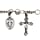

cross holy spirit yellow gold xmm inch necklace cross holy spirit yellow gold xmm inch necklace made highest quality metal shipped free pendant box make perfect gift also wear elegantly crafted symbol proudly brilliant exquisite way express anchor faith treasure keepsake years come jewelry comes satisfaction guarantee reassured happy purchase


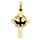

In [190]:
info_printer(7)
info_printer(8)

stockman vest every vest comes along thats versatile becomes favorite stockman designed worn proudly single layer valued layer warmth shell constructed genuine canadian melton wool oz strong lined premium grade taffeta distinctly western hardtailored whiskey nubuck trim featured front pocket welts western back yok piping buttons fine however quick release solid brass logo belt lin warth overall comfort mobility made usa


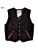

schaefer outfitters legend denim jacket remember first denim jacket stiff dark western today schaefer first design authentic cowboy denim jacket cowhide leather trimmed collar tailored doublestitch seams throughout double vshaped western yoke back matching western chest patch pockets slash hand warmer pockets adjustable button tab waist trimmed throughout schaefers signature twopiece die cast solid brass logo buttons extra roomy prewashed comfort truer fit cotton machine washable made usa


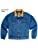

In [187]:
info_printer(14)
info_printer(12)

# create image embedding

In [275]:
from torchvision import models
import torch

from PIL import Image
import requests
from torchvision import transforms
from io import BytesIO

import torch.nn as nn

In [276]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 100)

In [277]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [398]:
# link = "https://github.com/aSafarpoor/open_repo_storhouse_for_nlp_Quran/blob/main/gray.png?raw=true"
# response = requests.get(link)
# grayimg = Image.open(BytesIO(response.content))

In [403]:
transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
    mean=[0.485, 0.456, 0.406],                #[6]
    std=[0.229, 0.224, 0.225]                  #[7]
)])

In [405]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [439]:
from PIL import Image

In [ ]:
response = requests.get("https://raw.githubusercontent.com/aSafarpoor/open_repo_storhouse_for_nlp_Quran/main/gray.png")
grayimg = Image.open(BytesIO(response.content))  

In [535]:
def im_reader(link , draw=False , pil=False):
    try:
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        
        if img.size[0]<256 or img.size[1]<256: 
            result = Image.new(img.mode, (400, 400), 100)
            result.paste(img, (100,100))
            img = result
    except:
            img = grayimg.copy()
    
    if img.mode == 'L':
            img = img.convert('RGB')

    if pil:
        img.show()
        return img
    im2arr = np.array(img)
    if draw:
        imgplot = plt.imshow(im2arr)
        plt.show()
    return im2arr

In [536]:
def batch_t_creator(url):
    img = im_reader(url,True,True)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

In [537]:
out_list = []
for i in tqdm(range(len(df))):
    imname = df.imageURL[i][0]
    batch_t = batch_t_creator(url=imname)
    out = alexnet(batch_t)
    out = out.detach().numpy()
    out_list.append(out)

100%|██████████| 8528/8528 [27:05<00:00,  5.25it/s]


In [538]:
# response = requests.get("https://images-na.ssl-images-amazon.com/images/I/314fCimuP-L._US40_.jpg")
# img = Image.open(BytesIO(response.content))
# print(img.size)

In [539]:
# rgbimg = img.convert('RGB')

# im2arr = np.array(img)
# print(im2arr.shape)

# im2arr = np.array(rgbimg)
# print(im2arr.shape)

In [540]:
# if rgbimg.size[0]<256 or rgbimg.size[1]<256: 
#             result = Image.new(rgbimg.mode, (400, 400), 100)
#             result.paste(rgbimg, (100,100))
#             img = result



In [541]:
# img.mode

In [548]:
df.embedding_of_img[0]

array([[-0.16994768,  0.18982676,  0.75423485,  0.43265396, -0.548987  ,
        -0.8334779 ,  0.21449575, -0.5469698 , -0.37343872,  0.3298336 ,
         0.45870197, -0.26444817, -0.44537354, -0.25101992,  0.4467347 ,
        -0.3807954 , -0.20300551,  0.08941248,  0.5112709 , -0.08515714,
         0.2585638 , -0.9361378 ,  0.31729266, -0.4139521 ,  1.34003   ,
         0.52313954, -0.38285178,  0.26412752,  0.1839196 , -0.82951623,
         0.16246235,  0.06309706,  0.11106266,  0.42828643, -0.6379764 ,
        -0.04531524,  0.08442929, -0.01516967, -0.00250925,  0.38967472,
        -0.08570734,  0.4291164 , -0.5878191 ,  0.9628032 ,  0.22006555,
        -0.45618382,  0.29540664, -0.12945098,  0.07978283, -0.3809228 ,
         0.29244474, -0.26406252,  0.27505618,  0.39576042, -0.4487237 ,
        -0.25566956,  0.05190525,  0.5065185 ,  0.6355765 ,  0.14743915,
         0.74384797, -0.28240708,  0.14826983, -0.04499435,  0.21008056,
        -0.13334998,  0.44833383, -0.3995029 ,  0.7

In [ ]:
tqdm.pandas()
df['embedding_of_img'] = out_list

In [561]:
def reshaper(a):
    a = np.array(a)
    # print(a.shape)
    if len(a.shape)==2:
        a = a.reshape(a.shape[-1])
    return a
df['embedding_of_img'] = df['embedding_of_img'].apply(reshaper)

In [562]:
np.array(df.embedding_of_img).shape,len(df.embedding_of_img[0]),len(df.embedding_of_img[1])

((8528,), 100, 100)

In [563]:
df.head(5)

,text,asin,imageURL,embedding_of_text,embedding_of_img
0,magical things really professional amateur mag...,1940280001,[https://images-na.ssl-images-amazon.com/image...,"[-0.5121693, 0.99798703, 0.42178416, 0.1645209...","[-0.16994768, 0.18982676, 0.75423485, 0.432653..."
1,carbon fiber money clip made usa pull extra la...,9654263246,[https://images-na.ssl-images-amazon.com/image...,"[-0.2718411, 0.57745373, -0.5244633, 0.1660285...","[-0.04363831, -0.04609757, 0.7264228, 0.378235..."
2,sterling silver cubic zirconia solitaire ring ...,B00061RFTW,[https://images-na.ssl-images-amazon.com/image...,"[-0.56256497, 0.8782094, -0.5621206, 0.5295459...","[-0.05984018, -0.08105918, 0.62606984, 0.33442..."
3,sterling silver cz marquise cut solitaire cubi...,B00061RG3M,[https://images-na.ssl-images-amazon.com/image...,"[-0.46838546, 0.72800905, -1.0693595, 0.507026...","[-0.07340459, 0.009561129, 0.6598038, 0.374966..."
4,calvin klein mens pack classic vneck tshirt ca...,B00062NHH0,[https://images-na.ssl-images-amazon.com/image...,"[0.12650906, -0.14532308, -0.06045738, 0.48030...","[-0.17253129, -0.22384281, 0.5896789, 0.724949..."


In [564]:
et = np.array(df.embedding_of_img)

In [565]:
def dot_product(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.dot(v1,v2)

def cosine_measure(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    prod = np.dot(v1,v2)
    len1 = math.sqrt(np.dot(v1, v1))
    len2 = math.sqrt(np.dot(v2, v2))
    return prod / (len1 * len2)

In [566]:
sim = np.zeros((len(et),len(et)))

In [567]:
for i in tqdm(range(len(et))):
    for j in range(len(et)):
        v1 = et[i]
        v2 = et[j]
        s = cosine_measure(v1, v2)
        sim[i][j] = s

100%|██████████| 8528/8528 [12:17<00:00, 11.56it/s]


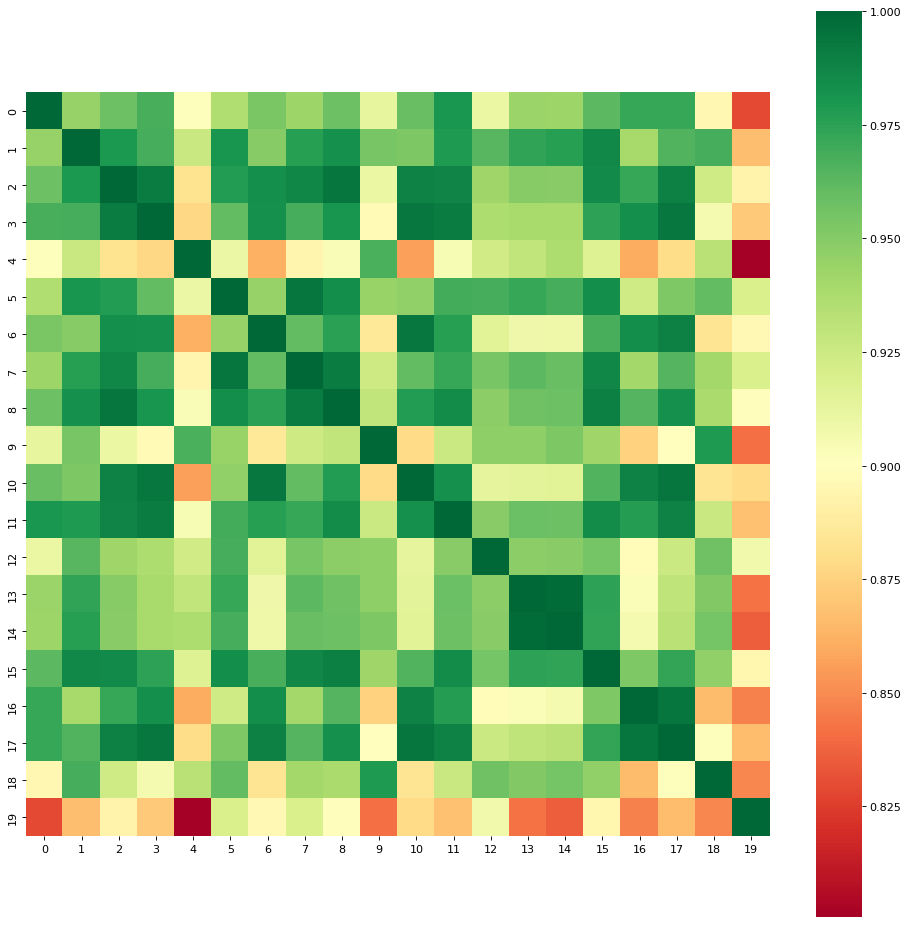

In [568]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=80)

ax = sns.heatmap(sim[:20,:20],cmap='RdYlGn',square=True)

plt.show()

In [573]:
simimg = sim[:]

In [569]:
def info_printer(n):
    print(df.text[n])
    imname = df.imageURL[n][0]
    os.system("wget "+ imname)
    imname = imname.split('/')[-1]
    im = cv2.imread(imname)
    os.system("rm "+ imname)
    cv2_imshow(im)

sterling silver cz marquise cut solitaire cubic zirconia ring sparkling magnificent sterling silver band measures approximately mm wide featuring elongated clear ct emerald cut cubic zirconia marquise shaped stone beautiful puts real diamonds shame get look real diamonds without hefty price tag ring shipped free gift box perfect surprising special someone


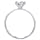

aa white pearl necklace inch necklace refined sophisticated features mm white freshwater aa quality cultured pearls


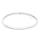

In [570]:
info_printer(3)
info_printer(10)

calvin klein mens pack classic vneck tshirt calvin klein basics comfortable cotton underwear original calvin klein aesthetic


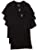

avalon masonic watcha 


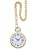

In [571]:
info_printer(4)
info_printer(16)

# save data as file

In [572]:
import pickle
with open('df_v_t_embedding.p', 'wb') as fp:
    pickle.dump(df, fp, protocol=pickle.HIGHEST_PROTOCOL)

# read data as file

# content based RS

In [582]:
simimg[:5,:5]

array([[1.        , 0.94534023, 0.95728435, 0.96731322, 0.9015719 ],
       [0.94534023, 1.        , 0.97944581, 0.96850335, 0.92611726],
       [0.95728435, 0.97944581, 1.        , 0.99176445, 0.88299931],
       [0.96731322, 0.96850335, 0.99176445, 1.        , 0.87750319],
       [0.9015719 , 0.92611726, 0.88299931, 0.87750319, 1.        ]])

In [583]:
simtxt[:5,:5]

array([[1.        , 0.66125688, 0.63801554, 0.56551098, 0.300835  ],
       [0.66125688, 1.        , 0.63086532, 0.54084793, 0.37884772],
       [0.63801554, 0.63086532, 1.        , 0.92591717, 0.47916739],
       [0.56551098, 0.54084793, 0.92591717, 1.        , 0.41814905],
       [0.300835  , 0.37884772, 0.47916739, 0.41814905, 1.        ]])

In [588]:
sim = (simimg[:] + 2*simtxt[:])/3

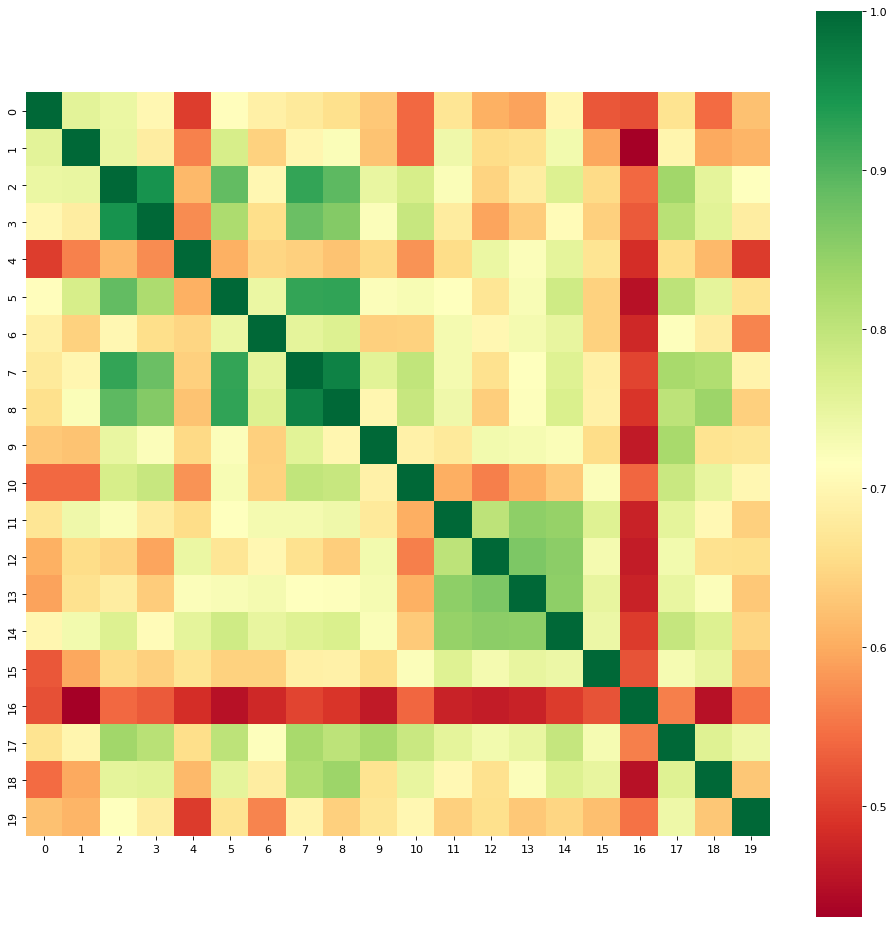

In [589]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(15, 15), dpi=80)
ax = sns.heatmap(sim[:20,:20],cmap='RdYlGn',square=True)
plt.show()

In [590]:
def info_printer(n):
    print(df.text[n])
    imname = df.imageURL[n][0]
    os.system("wget "+ imname)
    imname = imname.split('/')[-1]
    im = cv2.imread(imname)
    os.system("rm "+ imname)
    cv2_imshow(im)

sterling silver cubic zirconia solitaire ring emerald cut clear cz classically designed silver solitaire ring last lifetime expertly crafted ct clear emeraldcut cubic zirconia lays top sterling silver band mm wide ring timeless stack another ring wear alone make entire hand sparkle unbelievable price theres reason ring get ring shipped free gift box perfect surprising special someone


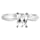

sterling silver cz marquise cut solitaire cubic zirconia ring sparkling magnificent sterling silver band measures approximately mm wide featuring elongated clear ct emerald cut cubic zirconia marquise shaped stone beautiful puts real diamonds shame get look real diamonds without hefty price tag ring shipped free gift box perfect surprising special someone


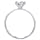

In [591]:
info_printer(2)
info_printer(3)

schaefer outfitters legend denim jacket remember first denim jacket stiff dark western today schaefer first design authentic cowboy denim jacket cowhide leather trimmed collar tailored doublestitch seams throughout double vshaped western yoke back matching western chest patch pockets slash hand warmer pockets adjustable button tab waist trimmed throughout schaefers signature twopiece die cast solid brass logo buttons extra roomy prewashed comfort truer fit cotton machine washable made usa


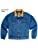

sterling silver cz marquise cut solitaire cubic zirconia ring sparkling magnificent sterling silver band measures approximately mm wide featuring elongated clear ct emerald cut cubic zirconia marquise shaped stone beautiful puts real diamonds shame get look real diamonds without hefty price tag ring shipped free gift box perfect surprising special someone


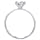

In [592]:
info_printer(12)
info_printer(3)

kt gold double trinity knot ring trinity knot simplest celtic design existence side bordered celtic knotwork beautiful simple celtic make even beautiful kt yellow gold


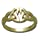

avalon masonic watcha 


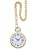

In [593]:
info_printer(18)
info_printer(16)

## read second table to find positive and negatice samples

In [594]:
###